In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ISLP
from torch import nn
from pytorch_lightning import Trainer
import sklearn
from sklearn.linear_model import LogisticRegression

Grad: -0.6373937155412455, Beta: 2.4637393715541243, Prev: 2.4
Grad: -0.6789207673130669, Beta: 2.531631448285431, Prev: 2.4637393715541243
Grad: -0.7196702414474325, Beta: 2.6035984724301744, Prev: 2.531631448285431
Grad: -0.7587382189178401, Beta: 2.6794722943219584, Prev: 2.6035984724301744
Grad: -0.7951091544568886, Beta: 2.7589832097676474, Prev: 2.6794722943219584
Grad: -0.8276935788190658, Beta: 2.841752567649554, Prev: 2.7589832097676474
Grad: -0.855383734746219, Beta: 2.927290941124176, Prev: 2.841752567649554
Grad: -0.877125133854918, Beta: 3.015003454509668, Prev: 2.927290941124176
Grad: -0.8919982814171284, Beta: 3.1042032826513806, Prev: 3.015003454509668
Grad: -0.8993010988960499, Beta: 3.1941333925409854, Prev: 3.1042032826513806
Grad: -0.8986200528677543, Beta: 3.283995397827761, Prev: 3.1941333925409854
Grad: -0.8898778517744346, Beta: 3.3729831830052044, Prev: 3.283995397827761
Grad: -0.8733484443280921, Beta: 3.4603180274380136, Prev: 3.3729831830052044
Grad: -0.8496

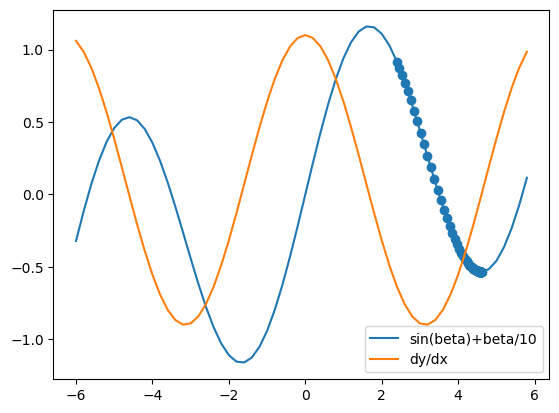

In [33]:
RHO = 0.1 #learning rate
MAX_ITERS = 1e3 #maximum iterations for GD
TOL = 1e-4 #tolerance before GD terminates


def main():
    R = lambda beta: np.sin(beta)+beta/10 
    x = np.arange(-6, 6, 0.2)
    y = R(x)
    

    dx = 1e-6
    dy = (R(x + dx) - R(x - dx)) / (2 * dx)
    plt.plot(x, y, label='sin(beta)+beta/10')
    plt.plot(x, dy, label='dy/dx')

    #gradient descent
    prev = 2.4
    betas = [prev]
    func = lambda beta: np.cos(beta) + 1/10
    iters = 0
    while True:
        grad = func(prev)
        beta = prev-RHO * grad
        print(f"Grad: {grad}, Beta: {beta}, Prev: {prev}")
        if abs(beta-prev) < TOL or iters>MAX_ITERS:
            break
        betas.append(beta)
        prev = beta
        iters+=1

    plt.scatter(betas, list(map(R, betas)))
    plt.legend()
    plt.show()

if __name__=="__main__":
    main()

In [35]:
from ISLP import load_data
Default = load_data('Default')
Default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [40]:
class Network(nn.Module):
    def __init__(self, size):
        super(Network, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(size, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.sequential(x)

In [47]:
NUM_EPOCHS = 20
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

Y = Default['default'].map({'Yes':1, 'No':0}).to_numpy()
X = Default.loc[:, ['balance', 'income']].to_numpy()
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size=0.3, random_state=1)

x_train_t = torch.tensor(x_train, dtype=torch.float32)
print(f"xtrain:{x_train_t.size()}")
x_test_t = torch.tensor(x_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.int64)
y_test_t = torch.tensor(y_test, dtype=torch.int64)

default_train = TensorDataset(x_train_t, y_train_t)
trainloader = DataLoader(default_train, batch_size=64, shuffle=False)

default_test = TensorDataset(x_test_t, y_test_t)
testloader = DataLoader(default_test, batch_size=64, shuffle=False)

model = Network(X.shape[1])
optimizer = optim.SGD(model.parameters(), lr = 3e-3)

#dimensions are [10,000, 4], one of the cols is called Yes or No if is a student

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

for e in range(NUM_EPOCHS):
    running_loss=0
    all_preds, all_labels = [], []

    for inputs, labels in trainloader:
        #print(f"Inputs:{inputs.size()}, Labels:{labels.size()}")
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
    epoch_accuracy = accuracy_score(all_labels, all_preds)

    print(f"Epoch {e+1}/{NUM_EPOCHS}")
    print(f"Loss: {running_loss/len(trainloader):.4f}, Accuracy: {epoch_accuracy:.4f}")

xtrain:torch.Size([7000, 2])
Epoch 1/20
Loss: 30.4440, Accuracy: 0.9584
Epoch 2/20
Loss: 0.4149, Accuracy: 0.9654
Epoch 3/20
Loss: 0.3674, Accuracy: 0.9654
Epoch 4/20
Loss: 0.3312, Accuracy: 0.9654
Epoch 5/20
Loss: 0.3031, Accuracy: 0.9654
Epoch 6/20
Loss: 0.2808, Accuracy: 0.9654
Epoch 7/20
Loss: 0.2628, Accuracy: 0.9654
Epoch 8/20
Loss: 0.2483, Accuracy: 0.9654
Epoch 9/20
Loss: 0.2362, Accuracy: 0.9654
Epoch 10/20
Loss: 0.2262, Accuracy: 0.9654
Epoch 11/20
Loss: 0.2177, Accuracy: 0.9654
Epoch 12/20
Loss: 0.2105, Accuracy: 0.9654
Epoch 13/20
Loss: 0.2044, Accuracy: 0.9654
Epoch 14/20
Loss: 0.1990, Accuracy: 0.9654
Epoch 15/20
Loss: 0.1944, Accuracy: 0.9654
Epoch 16/20
Loss: 0.1904, Accuracy: 0.9654
Epoch 17/20
Loss: 0.1869, Accuracy: 0.9654
Epoch 18/20
Loss: 0.1838, Accuracy: 0.9654
Epoch 19/20
Loss: 0.1810, Accuracy: 0.9654
Epoch 20/20
Loss: 0.1785, Accuracy: 0.9654
